In [1]:
import requests
from requests_html import HTMLSession
import arrow
from pathlib import Path
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=12, threads_per_worker=1)
client = Client(cluster)  # start local workers as processes

session = HTMLSession()
CWD = Path.cwd()
PDFS_DIR = CWD / 'pdfs'
PDFS_DIR.mkdir(exist_ok=True)

In [ ]:
pdf_list_r = session.get("https://travel.state.gov/content/travel/en/legal/visa-law0/visa-statistics/immigrant-visa-statistics/monthly-immigrant-visa-issuances.html")
pdf_list_content = pdf_list_r.html.find(".contentbody", first=True)
pdf_links = [link for link in pdf_list_content.find("a") if link.attrs["href"].endswith(".pdf")]
niv_pdf_list_r = session.get("https://travel.state.gov/content/travel/en/legal/visa-law0/visa-statistics/nonimmigrant-visa-statistics/monthly-nonimmigrant-visa-issuances.html")
niv_pdf_list_content = niv_pdf_list_r.html.find(".contentbody", first=True)
niv_pdf_links = [link for link in niv_pdf_list_content.find("a") if link.attrs["href"].endswith(".pdf")]


In [ ]:
urls_by_month = {}
for link in [*pdf_links, *niv_pdf_links]:
    link_text = link.text.replace(" - ", " - ").replace(" – ", " - ")

    month, _, category = link_text.partition(" - ")
    category = category.replace("Visa Cass", "Visa Class")  # lol

    if "NIV Issuances by Post and Visa Class" in category:
        urls_by_month["NIV-" + arrow.get(month, "MMMM YYYY").format("YYYY-MM")] = list(link.absolute_links)[0]
    elif "IV Issuances by Post and Visa Class" in category:
        urls_by_month["IV-" + arrow.get(month, "MMMM YYYY").format("YYYY-MM")] = list(link.absolute_links)[0]

In [ ]:
from itertools import product
for kind, month in product(["NIV", "IV"], arrow.Arrow.range('month', arrow.get("2017-03-01"), arrow.get())):
    outfile = (PDFS_DIR / f"{kind}-{month.format('YYYY-MM')}.pdf")
    if outfile.exists():
        print(f"skippy {outfile}")
        continue
    print(f"doin {outfile}")
    try:
        url = urls_by_month[f"{kind}-{month.format('YYYY-MM')}"]
    except KeyError:
        print(f"but no {outfile}!")
        continue
    r = requests.get(url)
    outfile.write_bytes(r.content)


skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-03.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-04.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-05.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-06.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-07.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-08.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-09.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-10.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-11.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2017-12.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2018-01.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2018-02.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2018-03.pdf
skippy /Users/underyx/me/visawhen/data/consulates/pdfs/NIV-2018-04.pdf
skippy

In [ ]:
import camelot
import pandas as pd
import PyPDF2

client.restart()

def process_path(path: Path, page_no: int) -> None:
    parsed = camelot.read_pdf(str(path), pages=str(page_no))
    table = parsed[0].df
    table.columns = ["Post", "Visa Class", "Issuances"]
    table["Issuances"] = pd.to_numeric(table["Issuances"].replace(r"\D", "", regex=True), errors='coerce', downcast="integer")
    table = table.replace("", pd.NA).dropna().reset_index(drop=True)
    table["Post"] = pd.Series(table["Post"], dtype="string")
    table["Visa Class"] = pd.Series(table["Visa Class"], dtype="string")
    table["Month"] = pd.Timestamp(arrow.get(path.name.replace("NIV-", "").replace("IV-", "").replace(".pdf", "")).format("YYYYMMDD"))
    table["Issuances"] = table["Issuances"].astype("uint16")
    return table

futures = []
for path in PDFS_DIR.glob("*.pdf"):
    page_count = PyPDF2.PdfFileReader(path.open("rb")).getNumPages()
    for page_no in range(1, page_count + 1):
        futures.append(client.submit(process_path, path, page_no))

results = client.gather(futures)
all_months = pd.concat(results).sort_values('Month').reset_index(drop=True)

In [ ]:
#cluster.scale(0)
cluster

In [ ]:
all_months[all_months["Issuances"] > 1000].head()

,Post,Visa Class,Issuances,Month
644,Ciudad Juarez,IR1,3374,2017-03-01
873,Warsaw,B1/B2,6192,2017-03-01
1029,Yekaterinburg,B1/B2,1303,2017-03-01
1054,Tijuana,H2A,3088,2017-03-01
1063,Tijuana,BBBCC,5530,2017-03-01


In [ ]:
all_months.to_pickle("all_months.pkl")

In [ ]:
bud_marriage = all_months.loc[all_months["Post"] == "Budapest"].loc[all_months["Visa Class"].isin(["CR1", "IR1"])].groupby(by=all_months["Month"]).sum()
bud_marriage

,Issuances
Month,
2017-03-01,3
2017-04-01,2
2017-05-01,6
2017-06-01,1
2017-07-01,1
2017-08-01,3
2017-09-01,2
2017-10-01,3
2017-11-01,3


In [ ]:
import seaborn as sns
sns.set_theme()


<AxesSubplot:xlabel='Month', ylabel='Issuances'>

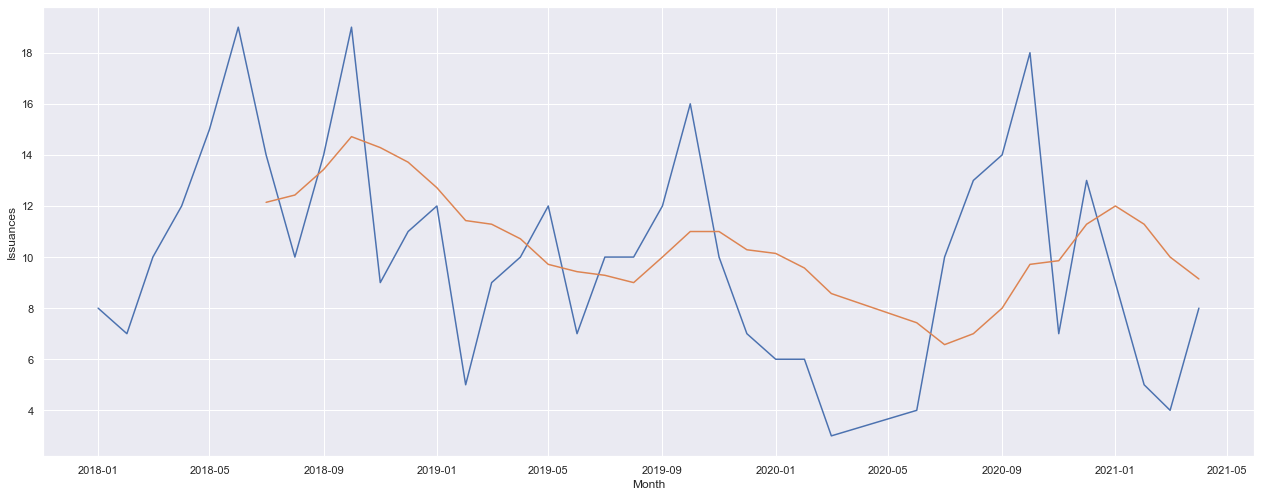

In [ ]:
bud_marriage['3mo_avg'] = bud_marriage["Issuances"].rolling(7).mean()
sns.lineplot(
    data=bud_marriage,
    x="Month", y="Issuances"
)
sns.lineplot(
    data=bud_marriage,
    x="Month", y="3mo_avg"
)


In [ ]:
(CWD / "bud.csv").write_text(bud_marriage.to_csv())

1027